In [1]:
import os
import sys
import yaml
import numpy as np
from pathlib import Path
from scipy import stats
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)

from class_load import LoadFiles
from factory_data import SQLDataSourceFactory, get_data
from factory_models import ModelContext  # , Modelos, Parameters_model
from factory_prepare_data import (DataCleaner, DataModel,
                                          MeanImputation, OutliersToIQRMean)
from features_fix_data import PrepareData

attempted relative import with no known parent package


In [2]:

# path_folder = os.path.dirname(__file__)abs
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction'
folder_model = Path(path_folder).joinpath('scr/data/save_models')

handler_load = LoadFiles()
# ruta_actual = os.path.dirname(__file__)
ruta_actual = path_folder
# #=================================================================
# #             Cargar datos de la fuente de datos 
# #=================================================================
CONFIG_FILE = Path(ruta_actual).joinpath('src/data/config/config.yaml')
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)

print("Probando el estacion de datos de sql")
data = get_data(SQLDataSourceFactory(**parameters))


Probando el estacion de datos de sql


In [3]:
new_types = []
base = {
    'date':np.datetime64,
    'integer': int,
    'float': float,
    'string': 'object',
}

for dtypo in parameters['type_data'].values():
    # print(dtypo)
    new_types.append(base[dtypo])

#metodo para transformar los tipo de datos
strategy = {
    int:np.mean,
    float:np.mean,
    object:stats.mode
}

#Estrategias para imputar los datos faltantes de NA
replace = {
    int:lambda x: int(float(x.replace(',',''))),
    float:lambda x: float(x.replace(',',''))
}

#Imputacion de los datos
imputation = MeanImputation(
                            replace_dtypes=new_types,
                            strategy_imputation=strategy,
                            preprocess_function=replace,
                            **parameters
                            )

#Patron de diseno de seleecion de estrategia
cleaner = DataCleaner(imputation)
data_imputation = cleaner.clean(data)

parameters_filter = parameters['filter_data']

handle_data = PrepareData(data_imputation.dataframe,**parameters['query_template'])

handle_data.filter_column(
    parameters_filter['filter_1_column'],
    parameters_filter['filter_1_feature'],
    string_filter=False
)

handle_data.filter_column(
    parameters_filter['filter_2_column'],
    parameters_filter['filter_2_feature'],
    string_filter=True
)

handle_data.get_expand_date(parameters_filter['date_column'])
handle_data.set_index_col(parameters_filter['date_column'])
handle_data.group_by_time(parameters_filter['predict_column'],frequency_group='D')

data_ready = handle_data.transforf_dataframe_dart(
    parameters_filter['date_column'],
    parameters_filter['predict_column']
)

In [4]:
MODE_USED = 'NBeatsModel'
modelo = ModelContext(model_name = MODE_USED,
                      data=data_ready,
                      split=83,
                      **parameters)


Modelo importado NBeatsModel


In [5]:
model_train = modelo.save_path.joinpath('model').with_suffix('.pt').as_posix()
scaler = modelo.save_path.joinpath('scaler').with_suffix('.pkl').as_posix()
last_pred =  modelo.save_path.joinpath('previus').with_suffix('.json').as_posix()
parameters = modelo.save_path.joinpath('parametros').with_suffix('.json').as_posix()

In [6]:
scaler = modelo.handle_loader.load_scaler(scaler)

In [7]:
last_prediction = handler_load.json_to_dict(last_pred)[0]

In [9]:
import pandas as pd
from DP_model import Modelos,Parameters_model

In [11]:
before, after = modelo.tunne_parameter.data.split_after(pd.Timestamp(last_prediction['last_date_pred']))
model_used_parameters = handler_load.json_to_dict(parameters)[0]
inst_model = Modelos[MODE_USED]
model_prepare = inst_model(**model_used_parameters)
modelo_cargado = model_prepare.load(model_train)

In [13]:
past_transform = scaler.transform(before)

predicciones = modelo_cargado.predict(
    series=before,
    n=30
)

# past_inv_transform = scaler.inverse_transform(predicciones)

Predicting: 0it [00:00, ?it/s]

In [18]:
past_transform_inv = scaler.inverse_transform(predicciones)

In [19]:
past_transform_inv

<TimeSeries (DataArray) (Fecha Creación: 30, component: 1, sample: 1)>
array([[[139383.16058346]],

       [[182885.72204125]],

       [[145612.52473619]],

       [[187650.23393533]],

       [[155412.9941097 ]],

       [[   217.94728054]],

       [[153194.09768736]],

       [[138712.70989369]],

       [[208575.83063705]],

       [[ 95465.10741302]],

...

       [[134174.52329003]],

       [[ 44045.32326919]],

       [[ 72130.06905332]],

       [[ -6387.02717833]],

       [[ 55983.23729792]],

       [[148556.40644238]],

       [[ 96844.33983362]],

       [[ 77042.51087314]],

       [[ 12100.77826245]],

       [[ 61993.53819694]]])
Coordinates:
  * Fecha Creación  (Fecha Creación) datetime64[ns] 2023-01-10 ... 2023-02-08
  * component       (component) object 'Cant Pedido UMV'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [74]:
from matplotlib import pyplot as plt
from matplotlib import cm
from darts.metrics import mape, r2_score, mse,mase,rmse,rho_risk, smape
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

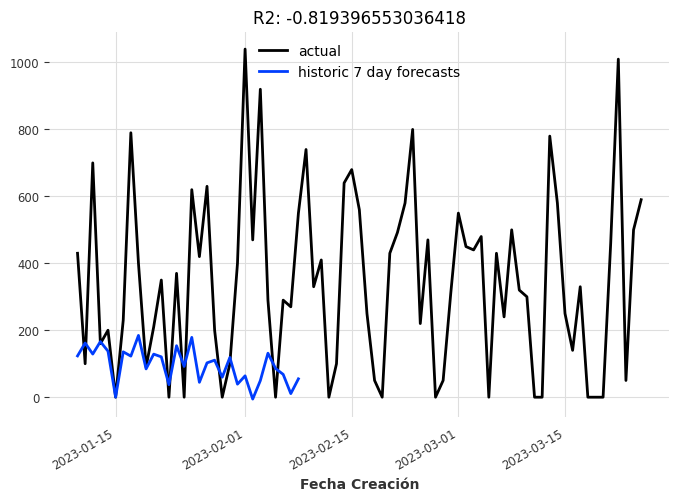

In [75]:
display_forecast(predicciones, modelo.tunne_parameter.data, "7 day", start_date=pd.Timestamp(last_prediction['last_date_pred']))